In [24]:
import glob

job_dir = '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/'

train_dirs = glob.glob(job_dir + '/**/training', recursive=True)


In [25]:
len(train_dirs)

1191

In [26]:
train_dirs[:10]

['/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1r1r2/pred_label_p0/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1r1r2/pred_label_p2/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1r1r2/pred_label_p4/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1r1r2/pred_label_p6/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1r1r2/pred_label_p8/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1s1r2/pred_label_p0/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1s1r2/pred_label_p2/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1s1r2/pred_label_p4/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1s1r2/pred_label_p6/training',
 '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/8/instance/5/e1

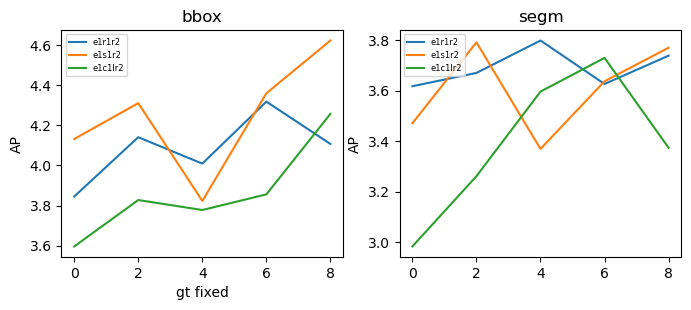

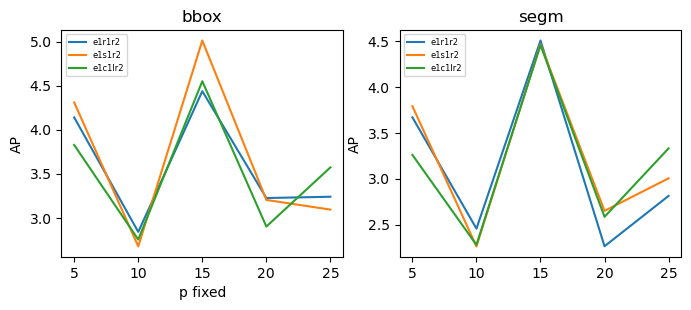

In [69]:
heuristics = [
    'e1r1r2',
    'e1s1r2', 
    # 'e1c1sr2', 
    'e1c1lr2', 
    # 'e1s1c1s', 
    # 'e1s1c1l', 
]

import json

def load_json(json_path):
    lines = []
    # print(f'looking at {json_path}')
    with open(json_path, 'r') as f:
        ls = f.readlines()
        for line in ls:
            try:
                lines.append(json.loads(line))
            except json.JSONDecodeError:
                print(f'JSONDecodeError {len(line), line[:2]}')
                continue
    return lines

from typing import Union
from collections import namedtuple, defaultdict
import numpy as np

AP = namedtuple('AP', 'bbox, segm')

def visualize(job_dir, setting):
    """
    visualize setting - gt fixed, p fixed
    draws as many lines as there are heuristic combinations 
    """

    def get_heuristic_gt_p(j):
        j = j.split('/')
        gt = j[j.index(setting)+1]
        heu = j[j.index(setting)+2]
        pred_label = j[j.index(setting)+3]
        p = pred_label[pred_label.find('pred_label_p') + len('pred_label_p'):]
        return heu, gt, p
    
    def get_best_ap(train_dir):
        """
        has metrics for each hyperparam set. 
        find lowest validation loss, and take corresponding training AP.
        """
        def get_ap(l):
            ap_bbox, ap_segm = 0, 0
            for k, v in l.items():
                if k.endswith('_val/bbox/AP'):
                    # print(k)
                    ap_bbox = l[k]
                if k.endswith('_val/segm/AP'):
                    # print(k)
                    ap_segm = l[k]
            return AP(ap_bbox, ap_segm)            
        
        def process_json(j):
            x = load_json(m)
            best_val, best_ap = float('inf'), AP(0, 0)
            for l in x:
                if 'validation_loss' in l:
                    val_loss = l['validation_loss']
                    if val_loss < best_val:
                        best_val = val_loss
                        best_ap = get_ap(l)
            return best_val, best_ap
        
        metric_jsons = glob.glob(train_dir + '/**/metrics.json', recursive=True)
        
        best_val, best_test_ap = float('inf'), AP(0,0)
        for m in metric_jsons:
            val_ap, test_ap = process_json(m)
            if val_ap < best_val:
                best_test_ap = test_ap
                best_val = val_ap
        
        # print(best_val, best_test_ap)
        return best_test_ap

    def process(j: str) -> Union[str, int, int, float]:
        # print(j)
        heu, gt, p = get_heuristic_gt_p(j)
        # print(heu, gt, p)
        
        #get best AP- this is not per json, but per pre_label_p0
        ap = get_best_ap(j)
        return heu, gt, p, ap
    
    tdirs = [x for x in train_dirs if setting in x]
    
    all_scores = defaultdict(list)
        
    # convert each json to <gt, p, best train AP>
    for t in tdirs:
        heu, gt, p, ap = process(t)
        # print(heu, gt, p, ap)
        all_scores['_'.join([heu, gt, p])].append(ap)
        # make a dataframe? to keep all these rows?
        # keep dict of heu, gt, p -> list of aps. then plot each heu separately
    
    def pprint(d):
        for k, v in d.items():
            print(k, v)
    
    # pprint(all_scores)
    
    def get_values(h, gt, p):
        key = '_'.join([h, str(gt), str(p)])
        if key in all_scores:
            aps = all_scores[key]
            return AP(np.average([p.bbox for p in aps]), np.average([p.segm for p in aps]))
        return None
    
    import matplotlib.pyplot as plt 
    
    def draw(heu, xs, ys_bbox, ys_segm, ax1, ax2, xlabel):
        ax1.set_title('bbox')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel('AP')
        ax1.errorbar(xs, ys_bbox, yerr=None, label=heu)
        ax1.legend(loc="upper left", prop={'size':6})
        
        ax2.set_title('segm')
        ax1.set_xlabel(xlabel)
        ax2.set_ylabel('AP')
        ax2.errorbar(xs, ys_segm, yerr=None, label=heu)
        ax2.legend(loc="upper left", prop={'size':6})

    
    def plot(gts, ps):
        # for each heuristic, plot gt, p
        if len(gts) == 1:
            # ps are the x-values
            # ap are the y-values 
            xs = ps
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
            for h in heuristics:
                ys_bb, ys_se = [], []
                for p in ps:
                    y_ap = get_values(h, gts[0], p)
                    if y_ap is not None:
                        ys_bb.append(y_ap.bbox)
                        ys_se.append(y_ap.segm)
                
                if len(ys_bb) > 0 and len(ys_se) > 0:
                    draw(h, xs, ys_bb, ys_se, ax1, ax2, 'gt fixed')
            plt.show()
            
        if len(ps) == 1:
            # gts are the x-values
            # ap are the y-values 
            xs = gts
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
            for h in heuristics:
                ys_bb, ys_se = [], []
                for gt in gts:
                    y_ap = get_values(h, gt, ps[0])
                    if y_ap is not None:
                        ys_bb.append(y_ap.bbox)
                        ys_se.append(y_ap.segm)
                
                if len(ys_bb) > 0 and len(ys_se) > 0:
                    draw(h, xs, ys_bb, ys_se, ax1, ax2, 'p fixed')
            plt.show()
            
            
    
    plot(gts=[5], ps=[0,2,4,6,8])
    plot(gts=[5,10,15,20,25], ps=[2])
    
visualize(job_dir, 'instance')
# visualize(job_dir, 'class')
